In [2]:
# import modules
import sys
from os import listdir, path
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!conda install -y pytorch==2.0.1 torchvision==0.15.2 pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install xarray

In [3]:
torch.version.cuda

'11.7'

In [309]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# constnats
AREA_WIDTH  = 17000
AREA_HIGHT = 3500

BLOCK_WIDTH  = 400
BLOCK_HEIGHT = 100

NUMBER_OF_SAMPLE = 301#401
NUMBER_OF_RECEIVERS = 341#401

Nx = 341
Ny = 351

dx = AREA_WIDTH / (Nx-1)
dy = AREA_HIGHT / (Ny-1)

In [6]:
print(f'Grid steps dx : {dx}, dy : {dy}')
nx, ny = int(BLOCK_WIDTH/dx), int(BLOCK_HEIGHT/dy)
print(f'Block size in nodes : ({nx}, {ny})')

Grid steps dx : 50.0, dy : 10.0
Block size in nodes : (8, 10)


## Prepare dataset

In [611]:
## read empty signal
import struct

X_empty = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
with open('seismogram.bin', 'rb') as fd :
    for i in range(NUMBER_OF_SAMPLE):
        ts = struct.unpack('d', fd.read(8))
        tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
        if(tmp.size == 0):
            break
        X_empty[0, i, :] = tmp[::2] #vx
        X_empty[1, i, :] = tmp[1::2] #vy

In [668]:
import struct

dir = "./dataset_mixed/vtk/"
# seismograms
X = {}
# target boxes
y = {}
# scalars
y_s = {}
weight_mask = {}

mask = np.zeros((Ny, Nx), dtype='bool')

x_p = np.arange(Nx, dtype='int')
y_p = np.arange(Ny, dtype='int')

X_p, Y_p = np.meshgrid(x_p, y_p)

# read signals
for file in listdir(dir):
    with open(dir+file, 'rb') as fd :
        str = file.split('_')
        x0 = int(int(str[1])/dx)
        y0 = int(int(str[2])/dy)
        y_sc = float(int(str[3][:str[3].find('.')]))

        signal = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
        for i in range(NUMBER_OF_SAMPLE):
            ts = struct.unpack('d', fd.read(8))
            tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
            if(tmp.size == 0):
                break
            signal[0, i, :] = tmp[::2] #- X_empty[0, i, :]#vx
            signal[1, i, :] = tmp[1::2] #- X_empty[1, i, :]#vy

        key = (x0, y0)

        dist = np.abs(X_p - \
                      ( (X_p < x0) * x0 + (X_p > (x0+nx)) * (x0+nx) + (X_p >= x0) * (X_p <= (x0+nx)) * X_p  )  )/ (5*nx) \
                      + np.abs(Y_p - \
                      ( (Y_p < y0) * y0 + (Y_p > (y0+ny)) * (y0+ny) + (Y_p >= y0) * (Y_p <= (y0+ny)) * Y_p  ) ) / (5*ny)

        tmp = np.exp(-dist)+ 15 / np.sqrt(Nx*Ny)

        if (key in X.keys()):
            X[key].append(signal)
            y[key].append(np.copy(mask))
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key].append(y_sc)
            weight_mask[key].append(tmp)

        else:
            X[key] = [signal]
            y[key] = [np.copy(mask)]
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key] = [y_sc]
            weight_mask[key] = [tmp]

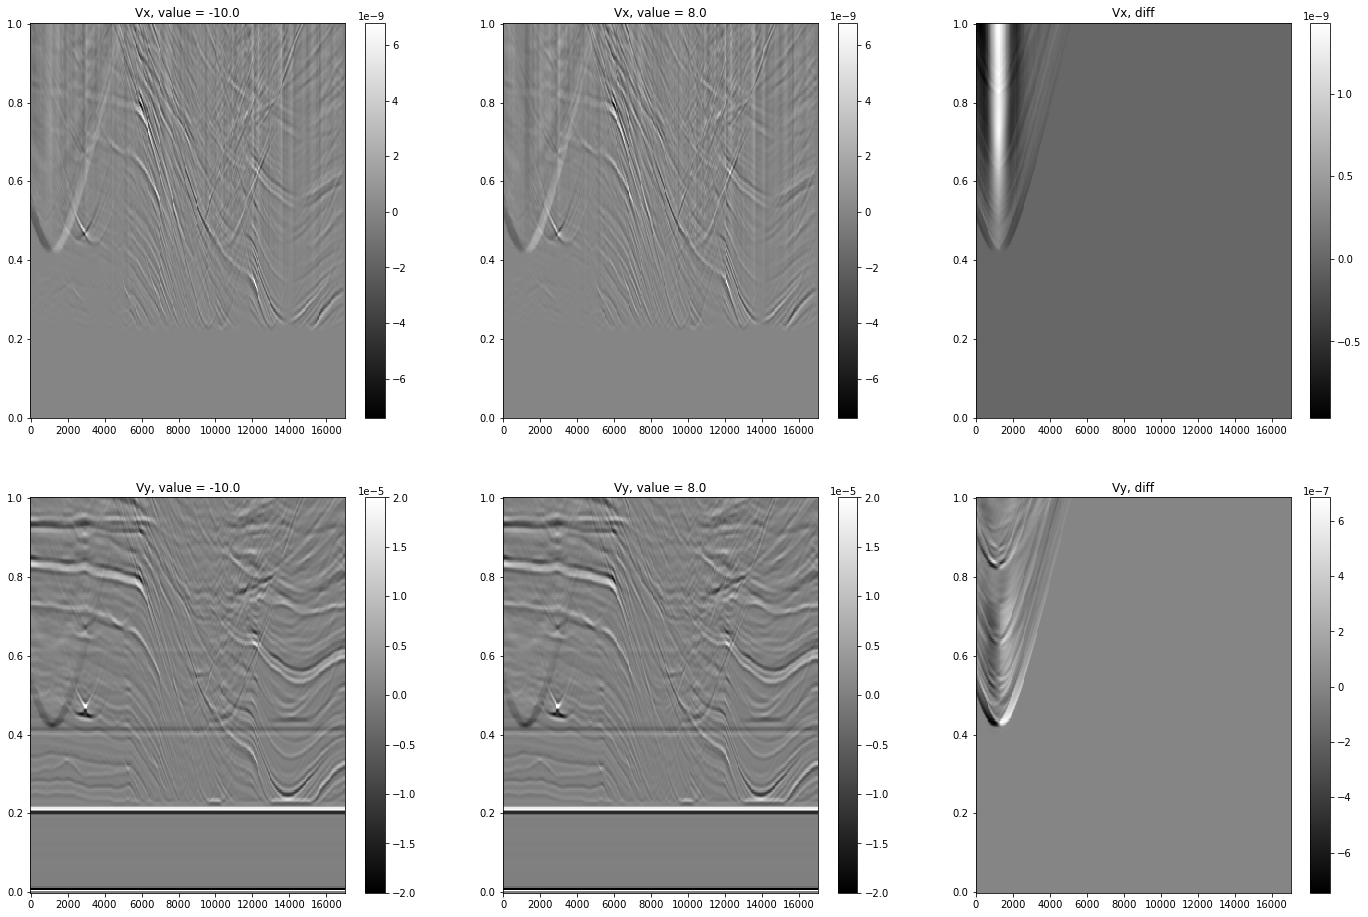

In [669]:
from matplotlib.pyplot import cm

# diference between two samples with same boxes
key = (int(1000/dx), int(1000/dy))
X_1 = X[key][0]
X_2 = X[key][-1]

v = np.max(abs(X_1))

x = np.linspace(0, AREA_WIDTH, NUMBER_OF_RECEIVERS)
t = np.linspace(0, 1, NUMBER_OF_SAMPLE)

fig, ax = plt.subplots(2, 3, figsize = (24, 16))
im = ax[0, 0].pcolormesh(x, t, X_1[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title(f'Vx, value = {y_s[key][0]}')
im = ax[0, 1].pcolormesh(x, t, X_2[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 1])
ax[0, 1].set_title(f'Vx, value = {y_s[key][-1]}')
im = ax[0, 2].pcolormesh(x, t, X_1[0, :]-X_2[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 2])
ax[0, 2].set_title(f'Vx, diff')

im = ax[1, 0].pcolormesh(x, t, X_1[1, :], cmap=cm.gray, vmax=2e-5, vmin=-2e-5)
plt.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title(f'Vy, value = {y_s[key][0]}')
im = ax[1, 1].pcolormesh(x, t, X_2[1, :], cmap=cm.gray, vmax=2e-5, vmin=-2e-5)
plt.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title(f'Vy, value = {y_s[key][-1]}')
im = ax[1, 2].pcolormesh(x, t, X_1[1, :]-X_2[1, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[1, 2])
ax[1, 2].set_title(f'Vy, diff')

plt.show()

For training segmentation only for each cluster position we will pick 6 random scalar values instead of considerinfg all values. This is needed to provide faster training for research needs

In [670]:
# train.test split
import random

test_size = 0.2

keys = list(X.keys())
random.shuffle(keys)
ind_split = int(len(keys) * test_size)

test_keys = keys[0:ind_split]
train_keys = keys[ind_split:-1]

X_test, y_test, y_s_test, wm_test = [], [], [], []
for key in test_keys:
    inds = list(range(len(X[key])))
    for ind in random.choices(inds, k=8):
        X_test.append(X[key][ind])
        y_test.append(y[key][ind])
        y_s_test.append(y_s[key][ind])
        wm_test.append(weight_mask[key][ind])
        
    '''
    for X_el, y_el, y_s_el in zip(X[key], y[key], y_s[key]):
        X_test.append(X_el)
        y_test.append(y_el)
        y_s_test.append(y_s_el)
    '''
    

X_train, y_train, y_s_train, wm_train = [], [], [], []
for key in train_keys:
    
    inds = list(range(len(X[key])))
    for ind in random.choices(inds, k=8):
        X_train.append(X[key][ind])
        y_train.append(y[key][ind])
        y_s_train.append(y_s[key][ind])
        wm_train.append(weight_mask[key][ind])
        
    '''
    for X_el, y_el, y_s_el in zip(X[key], y[key], y_s[key]):
        X_train.append(X_el)
        y_train.append(y_el)
        y_s_train.append(y_s_el)
    '''


Substract mean signal to elliminate background signal

In [671]:
# mean X signal

X_mean = np.zeros((2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS))

for x_el in X_train:
        X_mean += x_el / len(X_train)

In [672]:
for i in range(len(X_train)):
    X_train[i] -= X_mean

for i in range(len(X_test)):
    X_test[i] -= X_mean

In [673]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torchvision.transforms import Resize

resize = Resize((Ny, Nx))

class SeismicDataset(Dataset):
    def __init__(self, X, y, y_s, weight_mask, transform=resize):
        self.transform=transform
        self.X = deepcopy(X)
        self.y = deepcopy(y)
        self.y_s = deepcopy(y_s)
        self.w_m = deepcopy(weight_mask)

        # augmentation
        '''
        for x in X:
            self.X.append(x[:, :, ::-1])
        for y_el in y:
            self.y.append(y_el[:, ::-1])
        for y_el in y_s:
            self.y_s.append(y_el)
        for y_el in weight_mask:
            self.w_m.append(y_el[:, ::-1])
        '''

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X[idx].shape)
        X_out = torch.tensor(self.X[idx].copy())
        return  self.transform(X_out), torch.tensor(self.y[idx].copy()), torch.tensor(self.y_s[idx]), torch.tensor(self.w_m[idx].copy())

batch_size = 32

train_dataset = SeismicDataset(X_train, y_train, y_s_train, wm_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeismicDataset(X_test, y_test, y_s_test, wm_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [674]:
len(test_dataset)

304

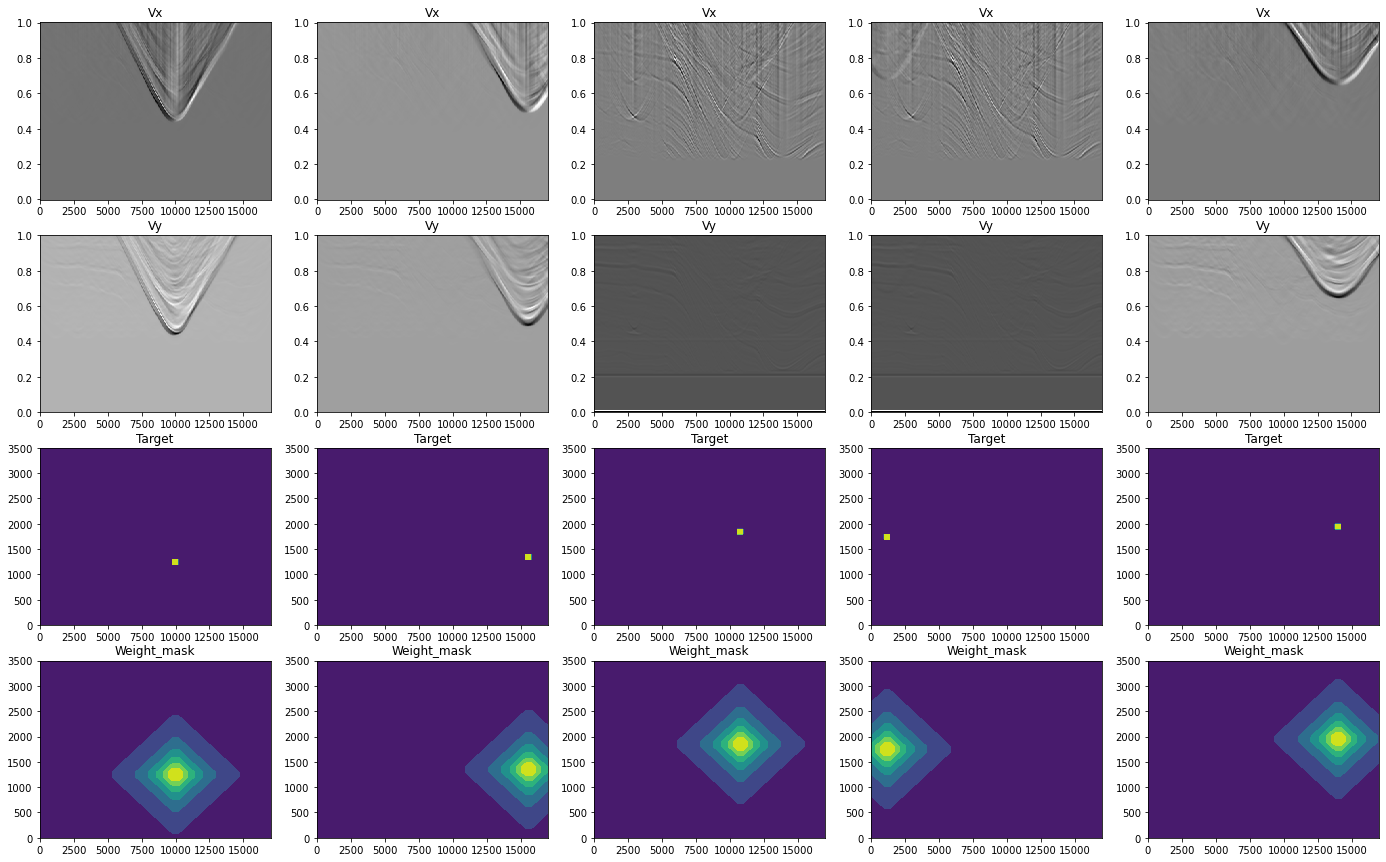

In [675]:
from matplotlib.pyplot import cm

X_1, y_1, y_s_1, wm_1 = next(iter(test_dataloader))

x = np.linspace(0, AREA_WIDTH, Nx)
t = np.linspace(0, 1, Ny)

fig, ax = plt.subplots(4, 5, figsize = (24, 15))

for i in range(5):
    ax[0, i].pcolormesh(x, t, X_1[i, 0, :], cmap=cm.gray)
    ax[0, i].set_title('Vx')
    ax[1, i].pcolormesh(x, t, X_1[i, 1, :], cmap=cm.gray)
    ax[1, i].set_title('Vy')
    ax[2, i].set_title('Target')
    ax[2, i].contourf(x, t*AREA_HIGHT, y_1[i, :])
    ax[3, i].set_title('Weight_mask')
    ax[3, i].contourf(x, t*AREA_HIGHT, wm_1[i, :], vmin = 0)

plt.show()

## Discussion of metrics :
Мы будем опираться на три метрики для оценки качества прогноза. Precision , Recall и Dice Score :
- $$ Precision = \frac{TP}{TP+FP} $$
- $$ Recall = \frac{TP}{TP+FN} $$
- $$ DiceScore(Y, \hat{Y}) = \frac{||Y \cap \hat{Y}|}{||Y||+||\hat{Y}||} $$
Precision позволит нам оценить возмодную переоценку размера кластера, Recall - пропущенные учатски кластера. Dice Score - даст информацию об общем соответсвии карты предсказания и карты разметки

### Default U-net architecture

In [692]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, size=None):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            if size == None:
                self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            else :
                self.up_sample = nn.Upsample(size = size, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_classes=1, up_sample_mode='bilinear'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        self.down_conv4 = DownBlock(64, 128)
        # Bottleneck
        self.double_conv = DoubleConv(128, 256)
        # Upsampling Path
        self.up_conv4 = UpBlock(128 + 256, 128, self.up_sample_mode, size = (43, 42))
        self.up_conv3 = UpBlock(64 + 128, 64, self.up_sample_mode, size = (87, 85))
        self.up_conv2 = UpBlock(64 + 32, 32, self.up_sample_mode, size = (175, 170))
        self.up_conv1 = UpBlock(32 + 16, 16, self.up_sample_mode, size = (351, 341))
        # Final Convolution
        self.conv_last = nn.Conv2d(16, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [693]:
from torch.nn import BCEWithLogitsLoss

class Loss_Metrics_Mem(object):
    
    def __init__(self):
        super().__init__()
        self.loss = None
        self.loss_h = []
        self.val_loss_h = []
        self.metrics_h = {}
        
    def upd_loss(self, loss_val):
        if self.loss is None:
             self.loss = loss_val
        else:
             self.loss = self.loss + loss_val
    def clean_loss(self):
        self.loss = None
            
    def upd_metrics(self, loss_val, metrics_val : dict):
        self.val_loss_h.append(loss_val)
        
        for key in metrics_val.keys() :
            if key in self.metrics_h.keys():
                self.metrics_h[key].append(metrics_val[key])
            else:
                self.metrics_h[key] = [metrics_val[key]]
        
        self.loss_h.append(self.loss)
        
    def plot(self, axes):
        xlen = len(self.loss_h)
        axes[0].plot(range(xlen), self.loss_h, label='train')
        axes[0].plot(range(xlen), self.val_loss_h, label='test')
        axes[0].legend()
        
        for key in self.metrics_h.keys():
            axes[1].plot(range(xlen), self.metrics_h[key], label=key)
            
        axes[1].legend()

## Weighted binary cross-entropy loss

В силу несбланасированности задачи (размер кластера много меньше размера области) необходимо ввести дополниетльный вес для положительной метки. Этот вес подбирался как доля площади так и линейная доля горизонтального растояния (по оси X). Последняя нормировка показала себя лучше в ходе обучения

In [710]:
## weight for loss
#weight_bce = 1 / (torch.sum(y_1[0, :, :]) / Nx/ Ny)
weight_bce = torch.tensor(AREA_WIDTH / BLOCK_WIDTH)
print(weight_bce)

tensor(42.5000)


In [711]:
model = UNet(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = BCEWithLogitsLoss(pos_weight=weight_bce)
l_m = Loss_Metrics_Mem()

In [712]:
# metrics in use

def Precision(y, y_pred):
    TP = torch.sum((y >= 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1./ Nx / Ny
    FP = torch.sum((y >= 0.5) * (y_pred < 0.5), axis = (1, 2)) * 1. / Nx / Ny
    return torch.sum( TP / (TP + FP + .5e-4) )

def Recall(y, y_pred):
    TP = torch.sum((y >= 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1. / Nx / Ny
    FN = torch.sum((y < 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1. / Nx / Ny
    return torch.sum(TP / (TP + FN + .5e-4))

def DiceScore(y_true, y_pred, gamma = 1):
    nominator = 2 * \
        torch.sum(y_pred * y_true, axis=(1, 2)) + 1e-5
    denominator = torch.sum(y_pred ** gamma, axis= (1, 2)) \
                  + torch.sum(y_true ** gamma, axis= (1, 2)) + 1e-5
    result = nominator / denominator
    return torch.sum(result)

def DistCent(Y, Y_pred):
    x_p = torch.linspace(0, 1, Y.shape[-1])
    y_p = torch.linspace(0, 1, Y.shape[-2])
    
    x_true = torch.clone(Y.float())
    x_pred = torch.clone(Y_pred)
    for i in range(torch.numel(x_p)):
        x_true[:, :, i] *= x_p[i]
        x_pred[:, :, i] *= x_p[i]
        
    denom_true = torch.sum(Y, axis = (1, 2))
    denom_pred = torch.sum(Y_pred, axis = (1, 2)) 
        
    x_c_t = torch.sum(x_true, axis = (1, 2)) / denom_true
    x_c_p = torch.sum(x_pred, axis = (1, 2)) / denom_pred
        
    y_true = torch.clone(Y.float())
    y_pred = torch.clone(Y_pred)
    for i in range(torch.numel(y_p)):
        y_true[:, i, :] *= y_p[i]
        y_pred[:, i, :] *= y_p[i]
        
    y_c_t = torch.sum(y_true, axis = (1, 2)) / denom_true
    y_c_p = torch.sum(y_pred, axis = (1, 2)) / denom_pred
    
    return torch.sum(1 - (x_c_t - x_c_p) ** 2 - (y_c_t - y_c_p) ** 2)
            

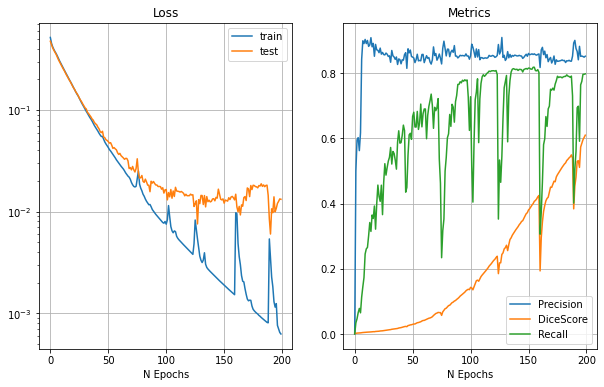

Loss on validation : 0.013233835735407313 
 Precision : 0.8516294579756888 
  Dice score : 0.6094795967403212 
  Recall : 0.7974120441235993 


In [715]:
N_epochs = 50

for epoch in range(N_epochs):
    
    model.train()
    for X, y, _, wm in train_dataloader:
        # X = X[:, 1, :, :].float().unsqueeze(1)z
        X = X.float()
        y = y.squeeze()
        y_pred = model(X.to(device)).squeeze()
        #Loss = BCEWithLogitsLoss(weight=wm.to(device))
        loss = Loss(y_pred.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * y.shape[0] / len(train_dataset))

    loss_val = 0.
    dist_score = 0.
    prec_score = 0.
    rec_score = 0.
    #model.eval()
    with torch.no_grad():
        for X,  y, _, wm in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred = model(X.to(device)).squeeze()
            #Loss = BCEWithLogitsLoss(weight=wm.to(device))
            loss = Loss(y_pred.float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #y_pred = torch.sigmoid(y_pred).to('cpu').detach()
            prec_score += Precision(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            dist_score += DiceScore(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            rec_score += Recall(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)

    l_m.upd_metrics(loss_val,
                    {
                        'Precision' : prec_score,
                        'DiceScore' : dist_score,
                        'Recall' : rec_score
                    })

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Metrics')
    l_m.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m.val_loss_h[-1] } \n',
        'Precision : {} \n '.format(l_m.metrics_h['Precision'][-1]),
        'Dice score : {} \n '.format(l_m.metrics_h['DiceScore'][-1]),
        'Recall : {} '.format(l_m.metrics_h['Recall'][-1]),
    )

    l_m.clean_loss()

Вывод, значение метрик выглядит приемлимо. Precision и Recall далее не растут, поэтому дальнейшее обучение можно не проводить

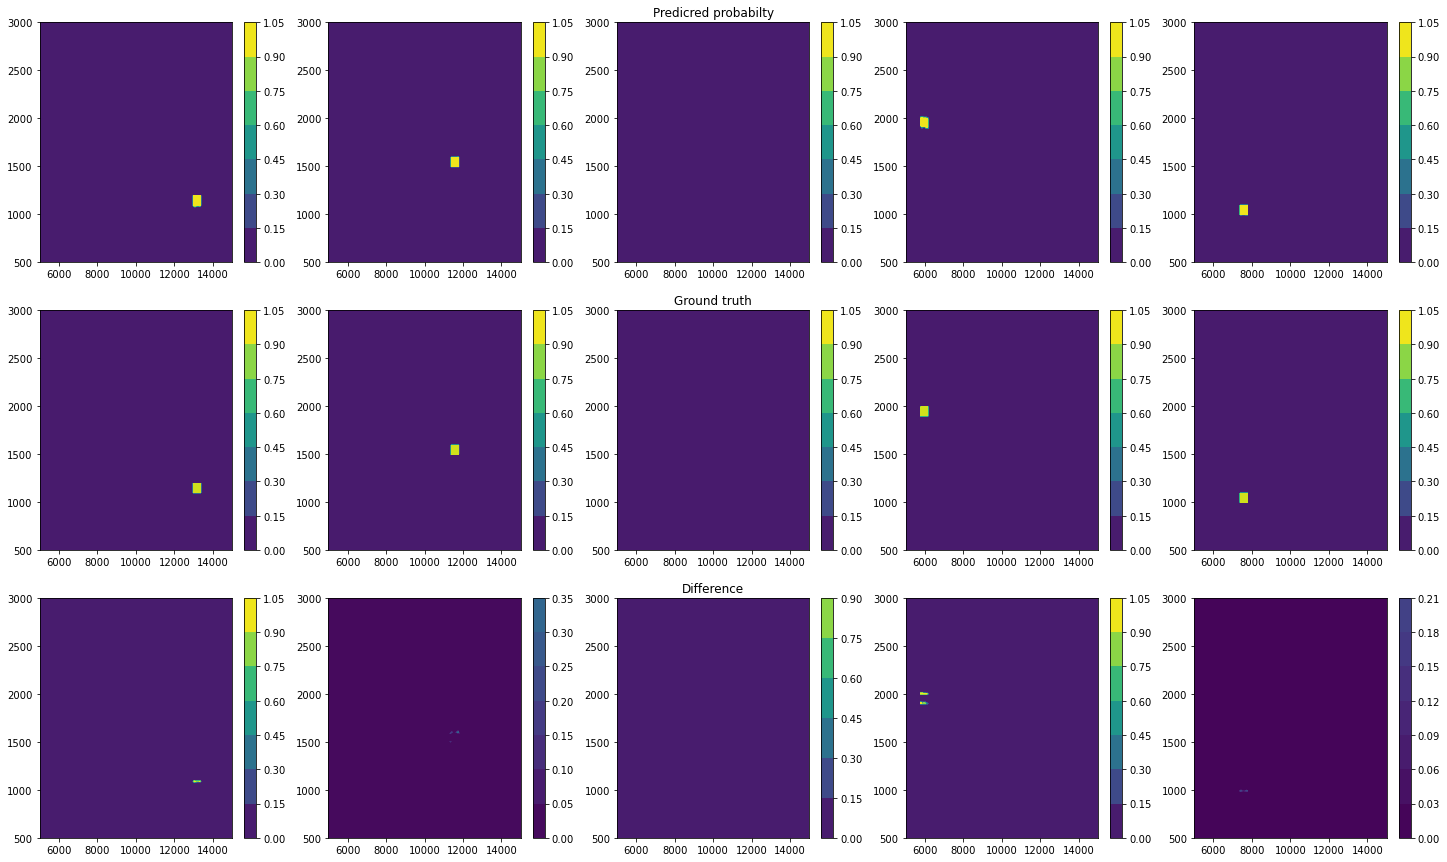

In [728]:
X, y, _, _ = next(iter(test_dataloader))

fig, ax = plt.subplots(3, 5, figsize = (25, 15))
#model.eval()
#with torch.no_grad():
y_pred = model(X.float().to(device)).squeeze().to('cpu').detach()

ax[0, 2].set_title('Predicred probabilty')
ax[1, 2].set_title('Ground truth')
ax[2, 2].set_title('Difference')

for i in range(5):
    im = ax[0, i].contourf(x, t * AREA_HIGHT, torch.sigmoid(y_pred[5+i, :]).numpy() , vmin=0, vmax=1)
    ax[0, i].set_ylim([500, 3000])
    ax[0, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[0, i])
    cm = ax[1, i].contourf(x, t * AREA_HIGHT, y[5+i, :].numpy())
    ax[1, i].set_ylim([500, 3000])
    ax[1, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[1, i])
    im = ax[2, i].contourf(x, t * AREA_HIGHT, np.abs(torch.sigmoid(y_pred[5+i, :]).numpy() - y[5+i, :].numpy()), vmin=0, vmax=1)
    ax[2, i].set_ylim([500, 3000])
    ax[2, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[2, i])

In [729]:
torch.save(model.state_dict(), 'BSE_vxvy_posweight.pt')

## Weighted mask
(Currently implemented wrong way)

In [730]:
model = UNet(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
#Loss = BCEWithLogitsLoss(pos_weight=weight_bce)
l_m_2 = Loss_Metrics_Mem()

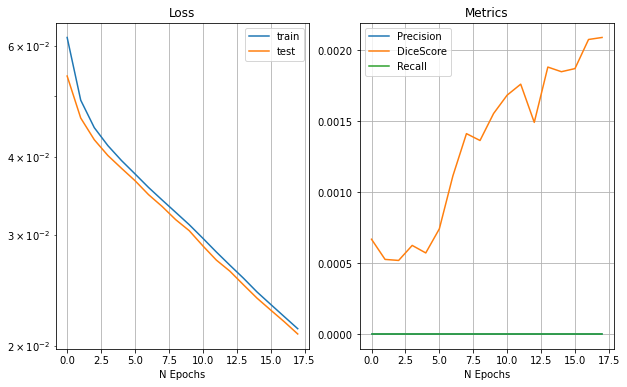

Loss on validation : 0.020878725440094344 
 Precision : 0.0 
  Dice score : 0.0020881760497822575 
  Recall : 0.0 


KeyboardInterrupt: 

In [731]:
N_epochs = 200

for epoch in range(N_epochs):

    model.train()
    for X, y, _, wm in train_dataloader:
        # X = X[:, 1, :, :].float().unsqueeze(1)z
        X = X.float()
        y = y.squeeze()
        y_pred = model(X.to(device)).squeeze()
        Loss = BCEWithLogitsLoss(weight=wm.to(device))
        loss = Loss(y_pred.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m_2.upd_loss(loss.item() * y.shape[0] / len(train_dataset))

    loss_val = 0.
    dist_score = 0.
    prec_score = 0.
    rec_score = 0.
    #model.eval()
    with torch.no_grad():
        for X,  y, _, wm in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred = model(X.to(device)).squeeze()
            Loss = BCEWithLogitsLoss(weight=wm.to(device))
            loss = Loss(y_pred.float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #y_pred = torch.sigmoid(y_pred).to('cpu').detach()
            prec_score += Precision(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            dist_score += DiceScore(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            rec_score += Recall(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)

    l_m_2.upd_metrics(loss_val,
                    {
                        'Precision' : prec_score,
                        'DiceScore' : dist_score,
                        'Recall' : rec_score
                    })

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Metrics')
    l_m_2.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m_2.val_loss_h[-1] } \n',
        'Precision : {} \n '.format(l_m_2.metrics_h['Precision'][-1]),
        'Dice score : {} \n '.format(l_m_2.metrics_h['DiceScore'][-1]),
        'Recall : {} '.format(l_m_2.metrics_h['Recall'][-1]),
    )

    l_m_2.clean_loss()

Результат предскзаания внешне кажется приемлимым, ошибка (вероятно) в Dcie score

## Dice loss

$$
DiceLoss(y, \hat{y}) = 1 - \frac{2 ||y \cap \hat{y}||}{||y||+||\hat{y}||}
$$

In [732]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6, gama=1):
        super(DiceLoss,self).__init__()
        self.smooth = smooth
        self.gama = gama

    def forward(self, y_true, y_pred):
        nominator = 2 * \
            torch.sum(y_pred * y_true, axis=(1, 2)) + self.smooth
        denominator = torch.sum(y_pred ** self.gama, axis= (1, 2)) \
                      + torch.sum(y_true ** self.gama, axis= (1, 2)) + self.smooth
        result = 1 - nominator / denominator
        return torch.sum(result) / torch.numel(result)

In [735]:
model = UNet(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
Loss = DiceLoss()
l_m_2 = Loss_Metrics_Mem()

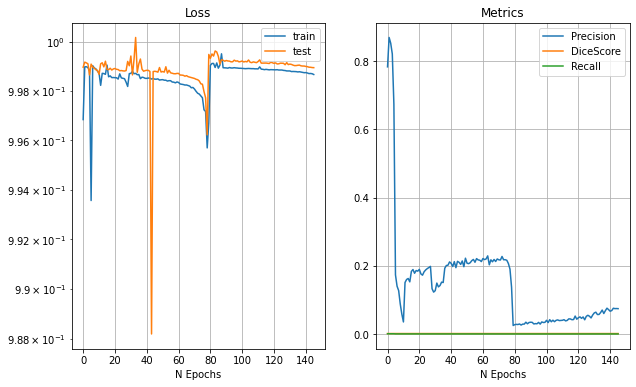

Loss on validation : 0.998944364095989 
 Precision : 0.0742942553601767 
  Dice score : 0.001281045309856142 
  Recall : 0.00010295711859055843 


KeyboardInterrupt: 

In [736]:
N_epochs = 200

for epoch in range(N_epochs):

    model.train()
    for X, y, _, wm in train_dataloader:
        # X = X[:, 1, :, :].float().unsqueeze(1)z
        X = X.float()
        y = y.squeeze()
        y_pred = model(X.to(device)).squeeze()
        #Loss = BCEWithLogitsLoss(weight=wm.to(device))
        loss = Loss(y_pred.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m_2.upd_loss(loss.item() * y.shape[0] / len(train_dataset))

    loss_val = 0.
    dist_score = 0.
    prec_score = 0.
    rec_score = 0.
    #model.eval()
    with torch.no_grad():
        for X,  y, _, wm in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred = model(X.to(device)).squeeze()
            #Loss = BCEWithLogitsLoss(weight=wm.to(device))
            loss = Loss(y_pred.float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #y_pred = torch.sigmoid(y_pred).to('cpu').detach()
            prec_score += Precision(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            dist_score += DiceScore(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            rec_score += Recall(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)

    l_m_2.upd_metrics(loss_val,
                    {
                        'Precision' : prec_score,
                        'DiceScore' : dist_score,
                        'Recall' : rec_score
                    })

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Metrics')
    l_m_2.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m_2.val_loss_h[-1] } \n',
        'Precision : {} \n '.format(l_m_2.metrics_h['Precision'][-1]),
        'Dice score : {} \n '.format(l_m_2.metrics_h['DiceScore'][-1]),
        'Recall : {} '.format(l_m_2.metrics_h['Recall'][-1]),
    )

    l_m_2.clean_loss()

Вывод : лосс падает очень слабо в сиул плохой диффернцируемости лосс-функции. Метрики крайне малы. Лучше данный лосс не использовать

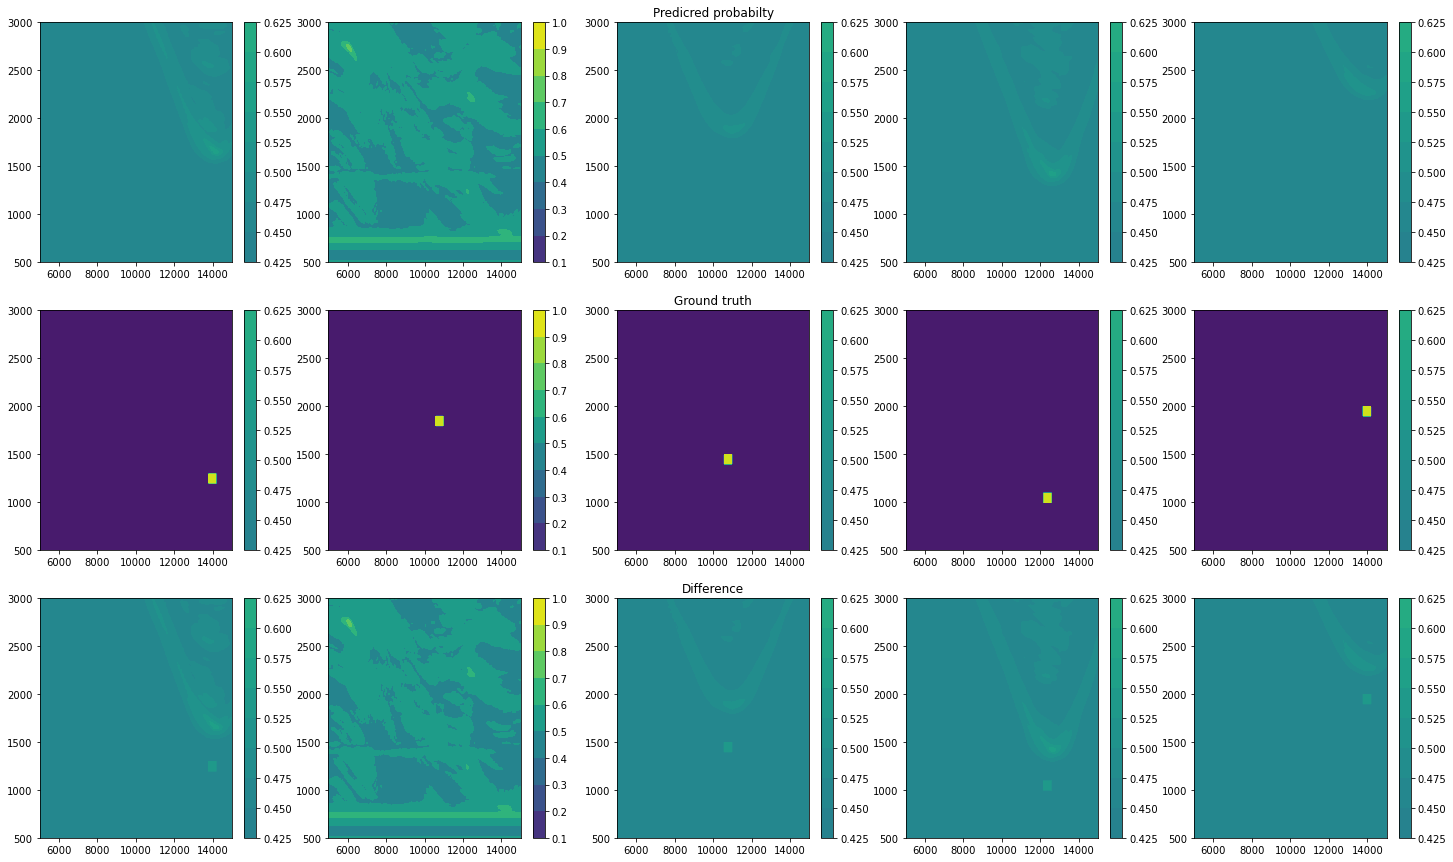

In [737]:
X, y, _, _ = next(iter(test_dataloader))

fig, ax = plt.subplots(3, 5, figsize = (25, 15))
#model.eval()
#with torch.no_grad():
y_pred = model(X.float().to(device)).squeeze().to('cpu').detach()

ax[0, 2].set_title('Predicred probabilty')
ax[1, 2].set_title('Ground truth')
ax[2, 2].set_title('Difference')

for i in range(5):
    im = ax[0, i].contourf(x, t * AREA_HIGHT, torch.sigmoid(y_pred[5+i, :]).numpy() , vmin=0, vmax=1)
    ax[0, i].set_ylim([500, 3000])
    ax[0, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[0, i])
    cm = ax[1, i].contourf(x, t * AREA_HIGHT, y[5+i, :].numpy())
    ax[1, i].set_ylim([500, 3000])
    ax[1, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[1, i])
    im = ax[2, i].contourf(x, t * AREA_HIGHT, np.abs(torch.sigmoid(y_pred[5+i, :]).numpy() - y[5+i, :].numpy()), vmin=0, vmax=1)
    ax[2, i].set_ylim([500, 3000])
    ax[2, i].set_xlim([5000, 15000])
    plt.colorbar(im, ax = ax[2, i])

In [738]:
torch.save(model.state_dict(), 'Dice_vxvy.pt')